In [3]:
# Install TensorFlow Addons for the Rectified Adam optimizer
# Note: As of TF 2.11+, some optimizers might be in tf.keras.optimizers.legacy
# but for this model, the standard Adam works great.

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import files

# --- Upload your CSV file ---
print("Please upload your GNSS .csv file.")
uploaded = files.upload()

# Get the filename of the uploaded file
file_name = next(iter(uploaded))
print(f"\nSuccessfully uploaded file: '{file_name}'")

Please upload your GNSS .csv file.


Saving generated_data.csv to generated_data.csv

Successfully uploaded file: 'generated_data.csv'


In [ ]:
# --- Configuration Parameters ---
N_TIMESTEPS_IN = 96   # Input: use 1 day (96 * 15 min) of data
N_TIMESTEPS_OUT = 96  # Output: predict the next 1 day (96 * 15 min)
N_FEATURES = 4        # Number of features: x, y, z, clockBias_x

# --- Load the dataset ---
# The file 'generated_data.csv' you uploaded is used here.
file_name = 'generated_data.csv'
df = pd.read_csv(file_name)

# --- IMPORTANT: Sort the data by time ---
# Time-series data must be in chronological order for the model to learn properly.
# We convert the 'epoch' column to a datetime format and then sort by it.
print("Sorting the data by the 'epoch' timestamp...")
df['epoch'] = pd.to_datetime(df['epoch'])
df.sort_values(by='epoch', inplace=True)


# --- Select the correct columns for training ---
# Your CSV has the columns: 'x', 'y', 'z', 'clockBias_x'
feature_columns = ['x', 'y', 'z', 'clockBias_x']

try:
    df_features = df[feature_columns]
    print("Successfully selected the following columns for training:")
    print(df_features.columns.tolist())
except KeyError:
    print(f"Error: Could not find all required columns {feature_columns} in the CSV.")
    raise

print("\nData Head (after sorting and selecting columns):")
print(df_features.head())

# --- Data Scaling ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_features)

# --- Create Input/Output Sequences ---
def create_sequences(data, n_in, n_out):
    """Converts time-series data into supervised learning sequences."""
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_in
        out_end_ix = end_ix + n_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, N_TIMESTEPS_IN, N_TIMESTEPS_OUT)
print(f"\nShape of input sequences (X): {X.shape}")
print(f"Shape of output sequences (y): {y.shape}")

# --- Train/Validation Split ---
split_index = X.shape[0] - 1
x_train, y_train = X[:split_index], y[:split_index]
x_val, y_val = X[split_index:], y[split_index:]

print(f"\nTraining data shape: x_train={x_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape (Day 7 input -> Day 8 output): x_val={x_val.shape}, y_val={y_val.shape}")

Sorting the data by the 'epoch' timestamp...
Successfully selected the following columns for training:
['x', 'y', 'z', 'clockBias_x']

Data Head (after sorting and selecting columns):
                x             y             z   clockBias_x
584  2.663004e+07  2.655815e+07  2.668173e+07  1.101681e-07
410  2.654687e+07  2.649579e+07  2.666804e+07 -3.651175e-07
450  2.645257e+07  2.651919e+07  2.668229e+07 -1.797892e-07
115  2.669829e+07  2.665302e+07  2.658280e+07 -3.249888e-08
394  2.653728e+07  2.648871e+07  2.640520e+07 -9.193236e-07

Shape of input sequences (X): (481, 96, 4)
Shape of output sequences (y): (481, 96, 4)

Training data shape: x_train=(480, 96, 4), y_train=(480, 96, 4)
Validation data shape (Day 7 input -> Day 8 output): x_val=(1, 96, 4), y_val=(1, 96, 4)


In [ ]:
# --- Positional Encoding (No changes here) ---
def positional_encoding(length, depth):
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.dense = layers.Dense(d_model)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.dense(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

# --- Transformer Encoder Block (FIXED) ---
class TransformerEncoder(layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        # The MultiHeadAttention layer has its own dropout parameter
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_ffn = layers.Dropout(dropout_rate)

    # --- 🛠️ FIX APPLIED HERE 🛠️ ---
    # The 'training' argument is now optional (training=None).
    # This allows the model to be built correctly. Keras will automatically pass
    # the correct True/False value during model.fit() or model.predict().
    def call(self, x, training=None):
        # Multi-head attention layer
        attn_output = self.mha(query=x, value=x, key=x, training=training)
        # Add & Norm
        out1 = self.layernorm1(x + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        # Add & Norm
        return self.layernorm2(out1 + ffn_output)

# --- Build the Full Model (No changes here) ---
def build_transformer_model(d_model=128, num_heads=8, dff=512, num_encoder_layers=4, dropout_rate=0.1):
    input_layer = layers.Input(shape=(N_TIMESTEPS_IN, N_FEATURES))
    x = PositionalEmbedding(d_model=d_model)(input_layer)
    for _ in range(num_encoder_layers):
        x = TransformerEncoder(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_layer = layers.Dense(N_TIMESTEPS_OUT * N_FEATURES, activation='linear')(x)
    output_layer = layers.Reshape((N_TIMESTEPS_OUT, N_FEATURES))(output_layer)
    return keras.Model(inputs=input_layer, outputs=output_layer)

# Instantiate and compile the model
model = build_transformer_model()
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['mean_absolute_error']
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_2          │ (None, 96, 128)        │           640 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 96, 128)        │       659,712 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 96, 128)        │       659,712 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, 96, 128)        │       659,712 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_5           │ (None, 96, 128)        │       659,712 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 384)            │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 96, 4)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689,024 (10.26 MB)

 Trainable params: 2,689,024 (10.26 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callback for Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Stop if val_loss doesn't improve for 10 epochs
    restore_best_weights=True
)

print("\n--- Starting Model Training ---")
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
print("--- Model Training Complete ---")


--- Starting Model Training ---
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.4237 - mean_absolute_error: 0.5128 - val_loss: 0.1370 - val_mean_absolute_error: 0.3025
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.1405 - mean_absolute_error: 0.3061 - val_loss: 0.0896 - val_mean_absolute_error: 0.2523
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.1050 - mean_absolute_error: 0.2718 - val_loss: 0.0866 - val_mean_absolute_error: 0.2492
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0982 - mean_absolute_error: 0.2647 - val_loss: 0.0841 - val_mean_absolute_error: 0.2482
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0955 - mean_absolute_error: 0.2621 - val_loss: 0.0828 - val_mean_absolute_error: 0.2458
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0939 - mean_absolute_error: 0.2606 - val_loss: 0.0807 - val_mean_absolute_error: 0.2409
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0927 - mean_

In [10]:
# --- Make Predictions ---
# Use the 7th day's data (x_val) to predict the 8th day
predicted_scaled = model.predict(x_val)

# --- Inverse Scale the Data to its Original Representation ---
predicted_values = scaler.inverse_transform(predicted_scaled.reshape(-1, N_FEATURES))
true_values = scaler.inverse_transform(y_val.reshape(-1, N_FEATURES))

# Reshape back to (timesteps, features)
predicted_values = predicted_values.reshape(N_TIMESTEPS_OUT, N_FEATURES)
true_values = true_values.reshape(N_TIMESTEPS_OUT, N_FEATURES)

# --- Evaluation at Different Horizons ---
horizons = [1, 2, 4, 8, 16, 24, 48, 96] # 15m, 30m, 1h, 2h, 4h, 6h, 12h, 24h
print("\n--- Model Evaluation at Different Horizons ---")
print("{:<15} {:<10} {:<10} {:<10}".format("Horizon", "RMSE", "MAE", "R²"))
print("-" * 50)

for h in horizons:
    horizon_index = h
    pred_h = predicted_values[:horizon_index, :]
    true_h = true_values[:horizon_index, :]

    rmse = np.sqrt(mean_squared_error(true_h, pred_h))
    mae = mean_absolute_error(true_h, pred_h)
    r2 = r2_score(true_h, pred_h)

    horizon_label = f"{h * 15} min"
    print(f"{horizon_label:<15} {rmse:<10.4f} {mae:<10.4f} {r2:<10.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- Model Evaluation at Different Horizons ---
Horizon         RMSE       MAE        R²        
--------------------------------------------------
15 min          74718.4208 56189.8643 nan       
30 min          82757.4430 64017.1550 -0.1046   
60 min          74659.9351 57201.3975 -0.1320   
120 min         73387.3847 56930.1570 -0.0354   
240 min         70703.4114 54591.4550 -0.0355   
360 min         75224.0635 57862.3428 0.0002    
720 min         77723.2593 59787.9360 -0.0001   
1440 min        73427.0388 55235.9700 -0.0008   


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


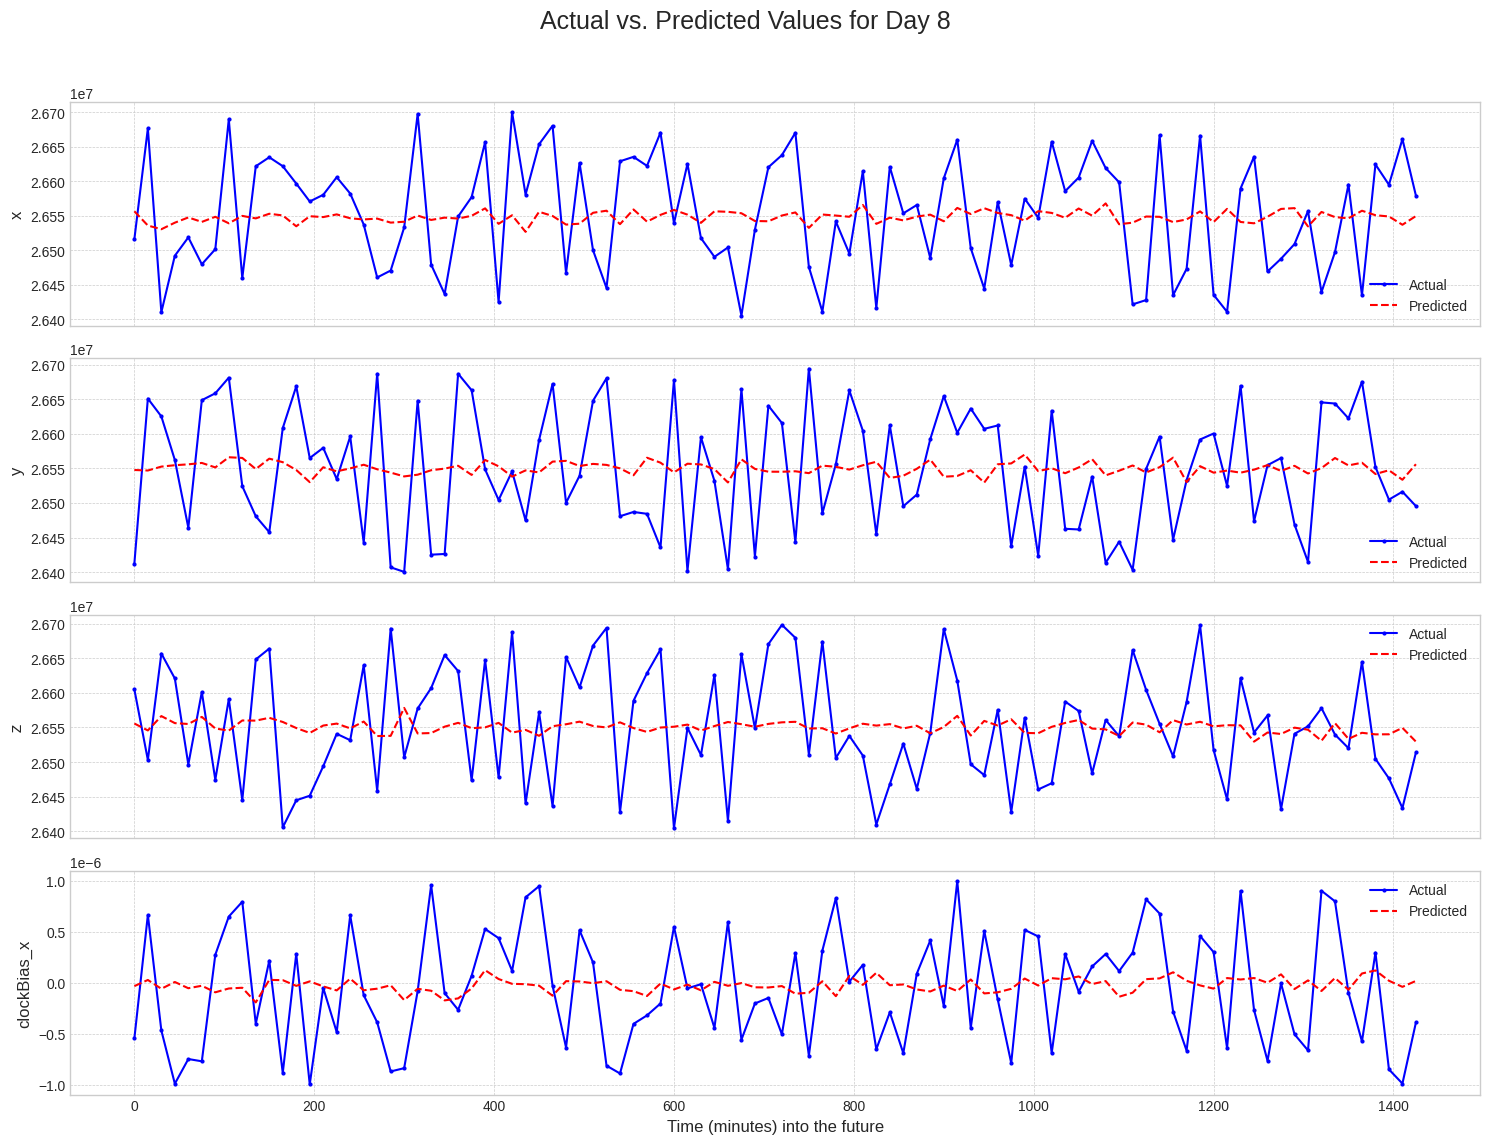

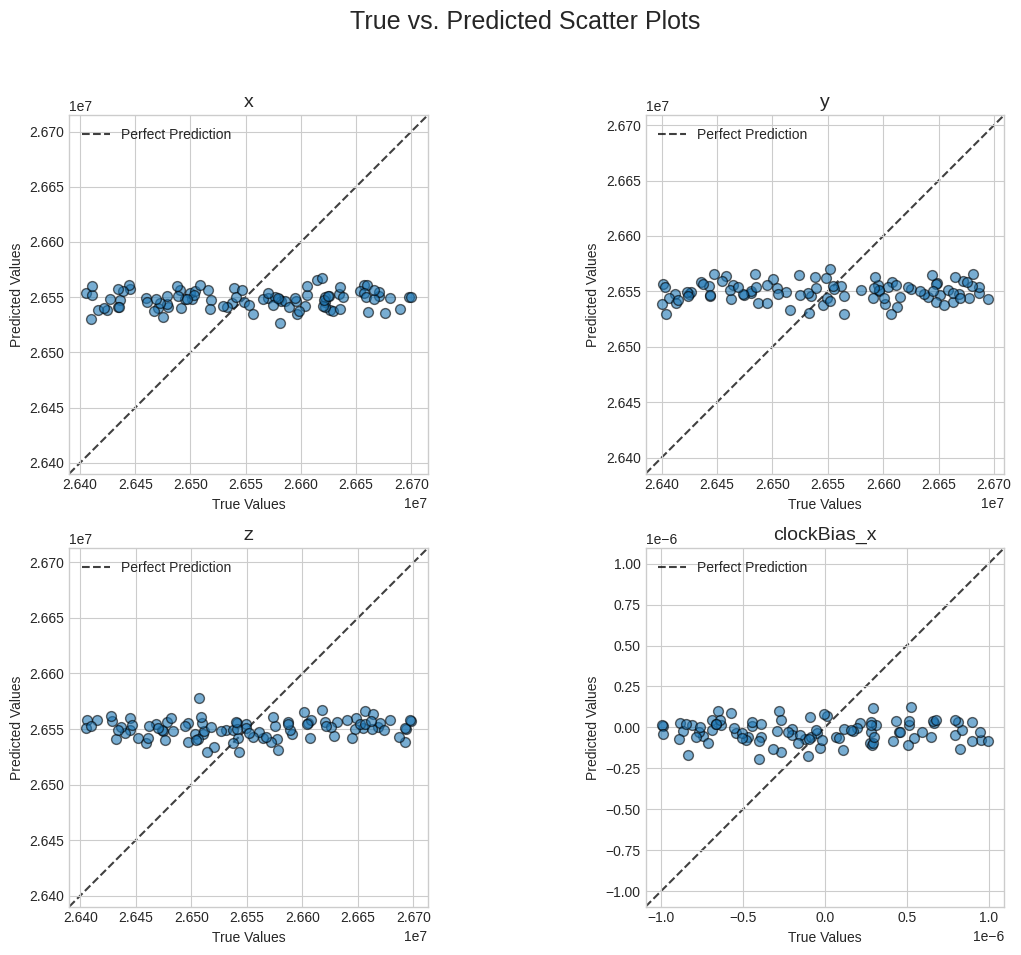

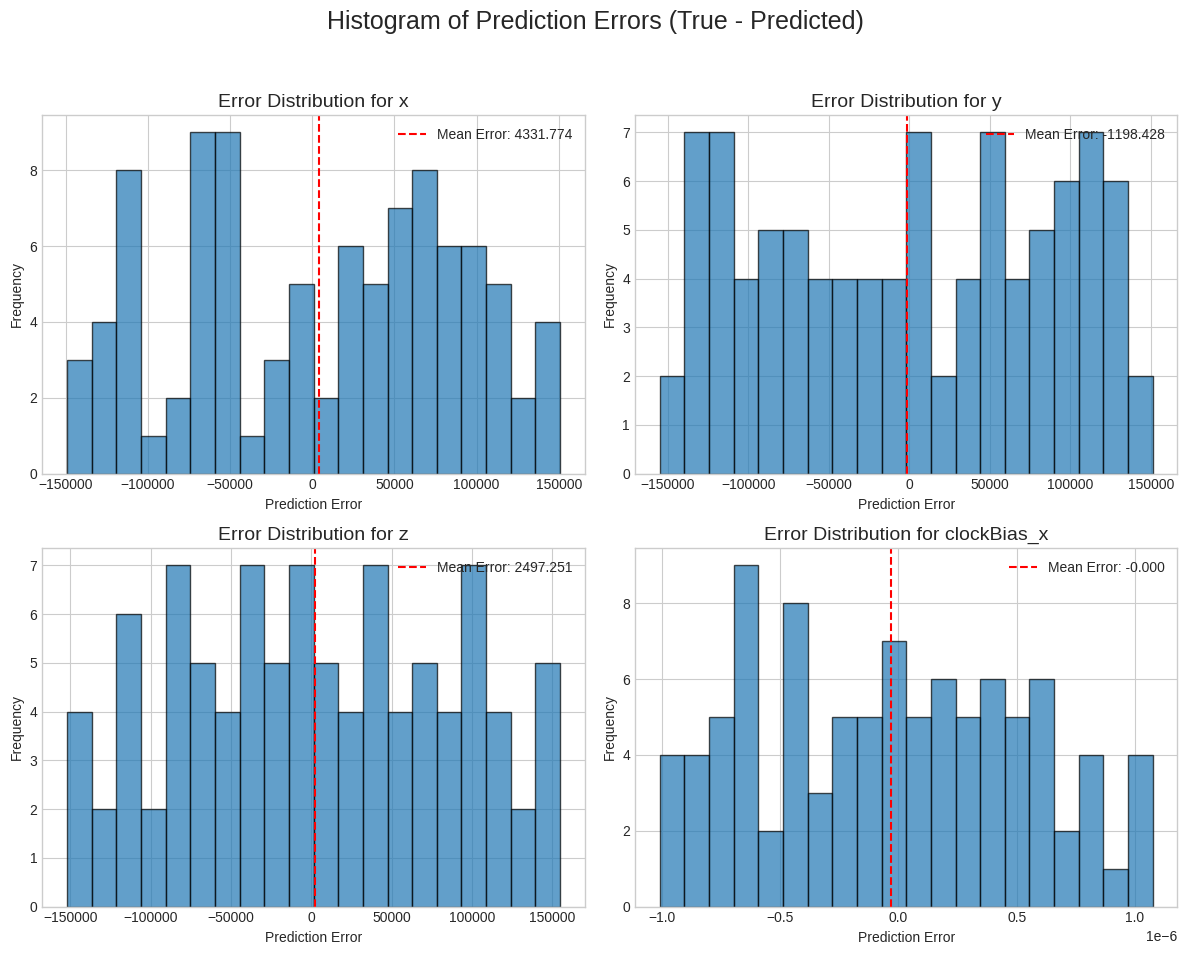

In [11]:
# --- 🛠️ CORRECTION 🛠️ ---
# We will use the 'feature_columns' list defined in Step 2 to ensure plot labels are correct.
feature_names = feature_columns
time_steps = np.arange(N_TIMESTEPS_OUT) * 15 # Time in minutes for the x-axis

# --- Plot 1: Actual vs. Predicted Values for Each Feature ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=N_FEATURES, ncols=1, figsize=(15, 12), sharex=True)
fig.suptitle('Actual vs. Predicted Values for Day 8', fontsize=18)

for i, ax in enumerate(axes):
    ax.plot(time_steps, true_values[:, i], label='Actual', color='blue', marker='.', markersize=4)
    ax.plot(time_steps, predicted_values[:, i], label='Predicted', color='red', linestyle='--')
    ax.set_ylabel(feature_names[i], fontsize=12)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

axes[-1].set_xlabel('Time (minutes) into the future', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# --- Plot 2: Scatter Plot of True vs. Predicted Values ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('True vs. Predicted Scatter Plots', fontsize=18)

for i, ax in enumerate(axes.flatten()):
    ax.scatter(true_values[:, i], predicted_values[:, i], alpha=0.6, edgecolors='k', s=50)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Perfect Prediction')
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(feature_names[i], fontsize=14)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Plot 3: Histogram of Prediction Errors ---
errors = true_values - predicted_values
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Histogram of Prediction Errors (True - Predicted)', fontsize=18)

for i, ax in enumerate(axes.flatten()):
    ax.hist(errors[:, i], bins=20, edgecolor='k', alpha=0.7)
    mean_err = errors[:, i].mean()
    ax.axvline(mean_err, color='red', linestyle='--', label=f'Mean Error: {mean_err:.3f}')
    ax.set_title(f'Error Distribution for {feature_names[i]}', fontsize=14)
    ax.set_xlabel('Prediction Error')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()